In [6]:
import pandas as pd
import torch
import numpy as np
from textblob import TextBlob
from transformers import AutoTokenizer
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ✅ Load dataset paths
train_path = "data/train.tsv"
valid_path = "data/valid.tsv"
test_path = "data/test.tsv"

In [3]:
# ✅ Label mapping (Convert to Binary: 1=True, 0=False)
LABEL_MAPPING = {
    "true": 1, "mostly-true": 1,
    "half-true": 0, "barely-true": 0, "false": 0, "pants-fire": 0
}

In [4]:
# ✅ Function to preprocess dataset
def preprocess_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None)
    df.columns = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                  "context1", "context2", "context3", "context4", "context5", "source"]
    
    # Convert Labels to Binary (1=True, 0=False)
    df["label"] = df["label"].map(LABEL_MAPPING)
    
    # Handle missing values (replace empty cells with "unknown")
    df.fillna("unknown", inplace=True)

    # Add Sentiment Score (extra feature)
    df["sentiment"] = df["statement"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    return df


In [5]:
# ✅ Load & Process Datasets
train_df = preprocess_data(train_path)
valid_df = preprocess_data(valid_path)
test_df = preprocess_data(test_path)

# ✅ Print dataset stats
print(f"Train Shape: {train_df.shape}, Valid Shape: {valid_df.shape}, Test Shape: {test_df.shape}")
print(train_df.head())

Train Shape: (10240, 15), Valid Shape: (1284, 15), Test Shape: (1267, 15)
           id  label                                          statement  \
0   2635.json      0  Says the Annies List political group supports ...   
1  10540.json      0  When did the decline of coal start? It started...   
2    324.json      1  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json      0  Health care reform legislation is likely to ma...   
4   9028.json      0  The economic turnaround started at the end of ...   

                              subject         speaker                   job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   



In [7]:
def create_three_key_visualizations(train_df, valid_df, test_df):
    # Combine all datasets for overall analysis
    all_df = pd.concat([train_df, valid_df, test_df], axis=0)
    
    # 1. Class Distribution with percentages
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='label', data=all_df, palette=['#FF5555', '#55BB55'])
    
    # Calculate percentages for labels
    total = len(all_df)
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{count} ({count/total*100:.1f}%)'
        ax.annotate(percentage, 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=12)
    
    plt.title('Distribution of True vs False Claims', fontsize=16)
    plt.xlabel('Label (1=True, 0=False)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation Heatmap between key features
    plt.figure(figsize=(12, 10))
    
    # Add statement length as a feature
    all_df['statement_length'] = all_df['statement'].apply(lambda x: len(str(x).split()))
    
    # Select relevant columns for correlation analysis
    selected_cols = ['label', 'sentiment', 'statement_length', 
                     'context1', 'context2', 'context3', 'context4', 'context5']
    
    # Create correlation matrix
    corr_matrix = all_df[selected_cols].corr()
    
    # Create heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
                linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Correlation Heatmap of Features', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 3. True vs False distribution by political party
    plt.figure(figsize=(14, 8))
    
    # Get major parties (with more than 100 statements)
    party_counts = all_df['party'].value_counts()
    major_parties = party_counts[party_counts > 100].index.tolist()
    party_df = all_df[all_df['party'].isin(major_parties)]
    
    # Create cross-tabulation and calculate percentages
    party_truth = pd.crosstab(party_df['party'], party_df['label'])
    party_truth_pct = party_truth.div(party_truth.sum(axis=1), axis=0) * 100
    
    # Plot stacked bar chart
    ax = party_truth_pct.plot(kind='bar', stacked=True, 
                             colormap='coolwarm', figsize=(12, 7))
    
    # Add value labels on bars
    for c in ax.containers:
        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center')
    
    plt.title('Percentage of True vs False Claims by Political Party', fontsize=16)
    plt.xlabel('Political Party', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.legend(['False', 'True'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\M. Hamza Khalid\AppData\Local\Temp\ipykernel_14168\3683117246.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=all_df, palette=['#FF5555', '#55BB55'])


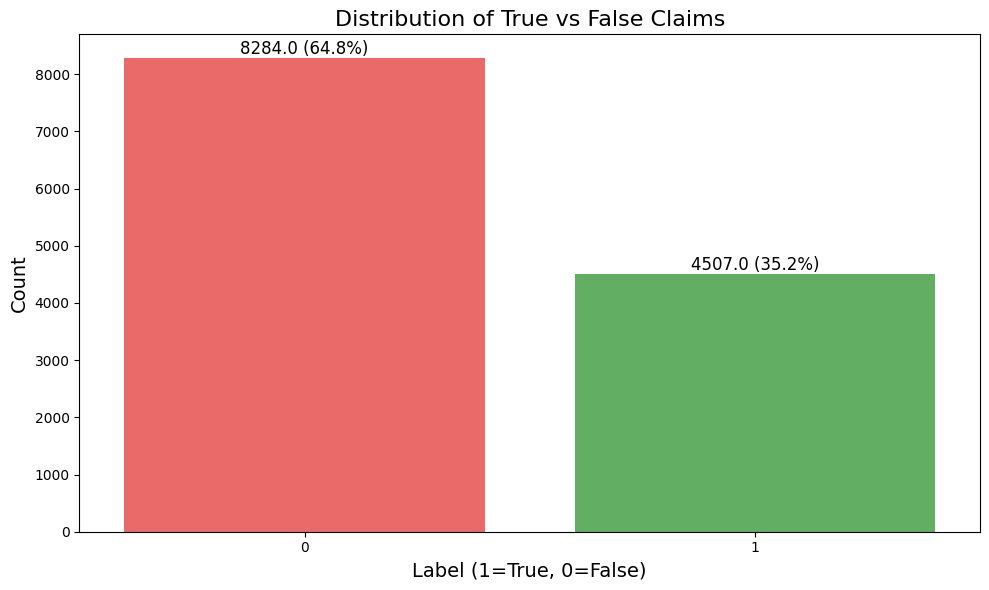

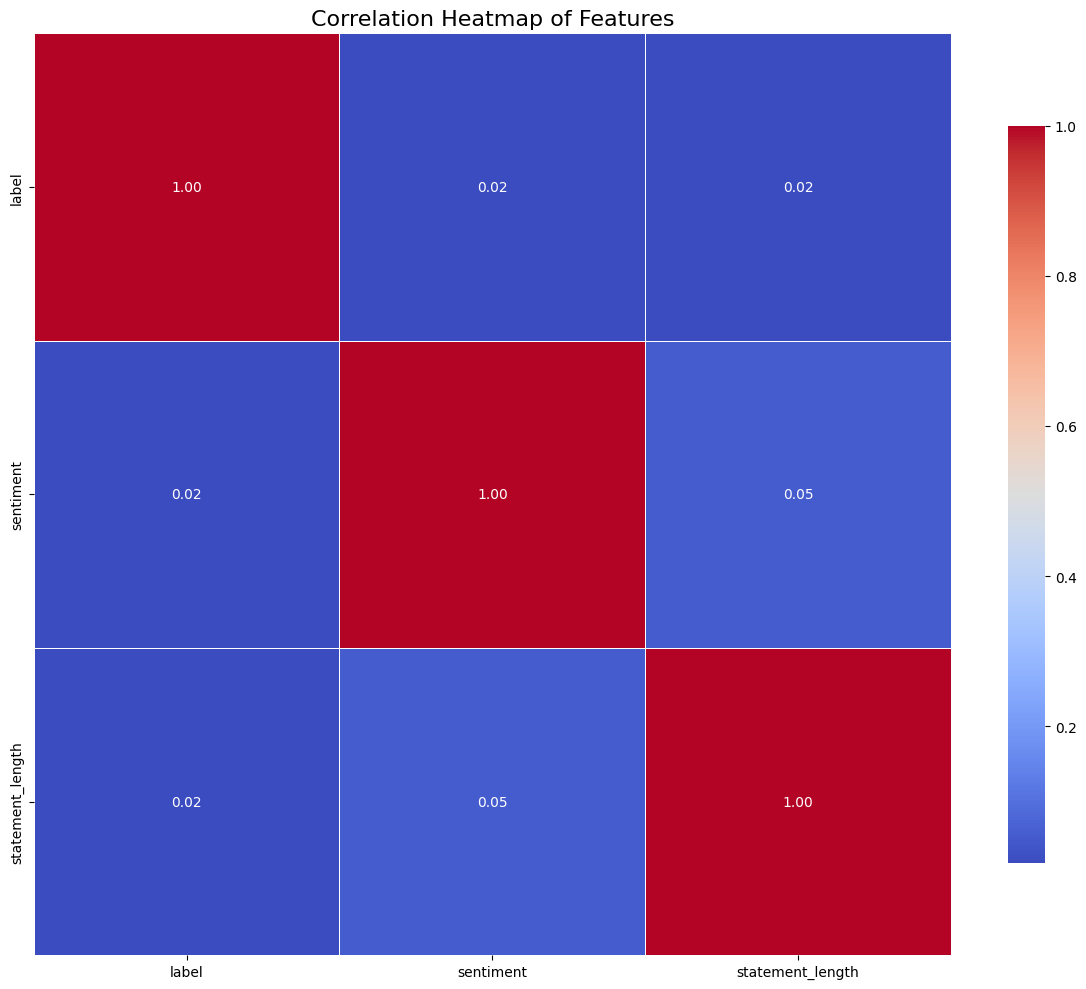

<Figure size 1400x800 with 0 Axes>

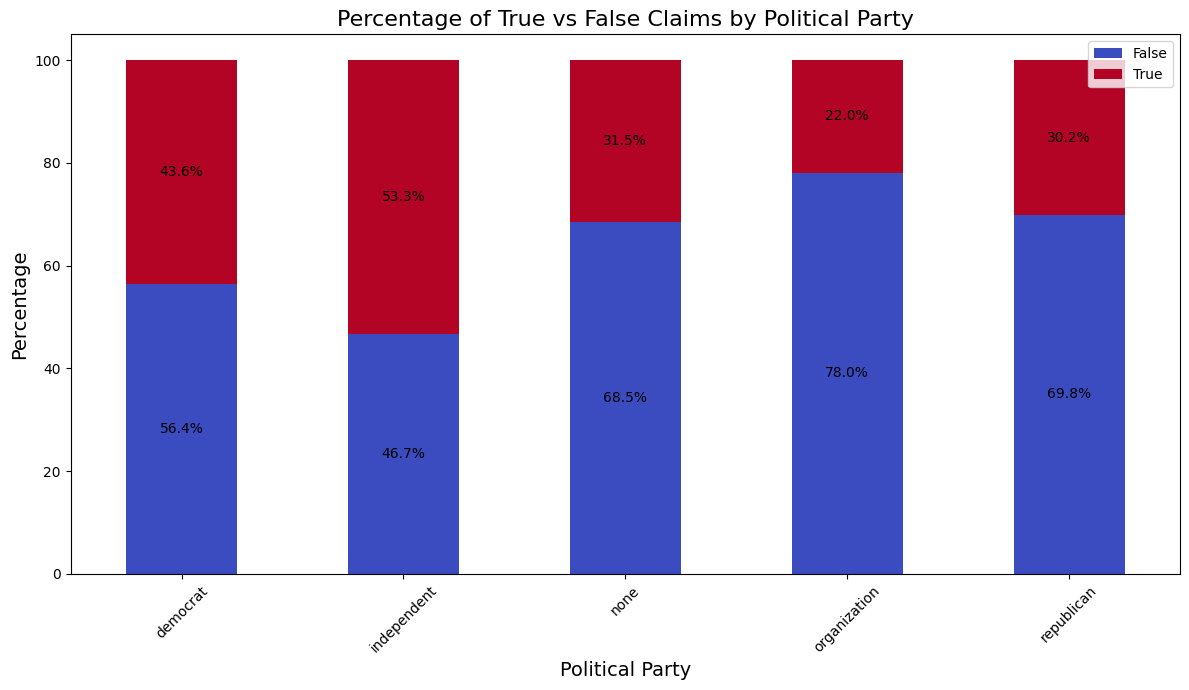

In [8]:
create_three_key_visualizations(train_df, valid_df, test_df)

In [16]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# ✅ Load Tokenizer & Model
BERT_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2).to("cuda")

# ✅ Prepare Dataset
def tokenize_function(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True, max_length=256)

train_dataset = HFDataset.from_pandas(train_df[["statement", "label"]])
valid_dataset = HFDataset.from_pandas(valid_df[["statement", "label"]])
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.remove_columns(["statement"])
valid_dataset = valid_dataset.remove_columns(["statement"])
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# ✅ Training Config
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,  
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    logging_steps=20,
    load_best_model_at_end=True,
    fp16=True,
)

# ✅ Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

trainer.train()

# ✅ Evaluate BERT Model
results = trainer.evaluate()
print(f"📊 BERT Test Accuracy: {results['eval_loss']:.2f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1284/1284 [00:00<00:00, 9341.92 examples/s]
c:\Users\M. Hamza Khalid\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\M. Hamza Khalid\AppData\Local\Temp\ipykernel_16188\3036579469.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  0%|          | 0/1280 [00:00<?, ?it/s]c:\Users\M. Hamza Khalid\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\mode

{'loss': 0.6622, 'grad_norm': 7.155488967895508, 'learning_rate': 1.9703125e-05, 'epoch': 0.06}


  3%|▎         | 40/1280 [00:14<04:51,  4.26it/s]

{'loss': 0.6603, 'grad_norm': 2.4822514057159424, 'learning_rate': 1.9390625000000002e-05, 'epoch': 0.12}


  5%|▍         | 60/1280 [00:19<04:49,  4.21it/s]

{'loss': 0.643, 'grad_norm': 3.059074878692627, 'learning_rate': 1.9078125e-05, 'epoch': 0.19}


  6%|▋         | 80/1280 [00:23<04:43,  4.23it/s]

{'loss': 0.622, 'grad_norm': 4.7503509521484375, 'learning_rate': 1.8765625e-05, 'epoch': 0.25}


  8%|▊         | 100/1280 [00:28<04:39,  4.21it/s]

{'loss': 0.6242, 'grad_norm': 5.443256378173828, 'learning_rate': 1.8453125e-05, 'epoch': 0.31}


  9%|▉         | 120/1280 [00:33<04:35,  4.21it/s]

{'loss': 0.6136, 'grad_norm': 5.62962007522583, 'learning_rate': 1.8140625000000002e-05, 'epoch': 0.38}


 11%|█         | 140/1280 [00:38<04:37,  4.11it/s]

{'loss': 0.6202, 'grad_norm': 3.3084397315979004, 'learning_rate': 1.7828125e-05, 'epoch': 0.44}


 12%|█▎        | 160/1280 [00:43<04:32,  4.11it/s]

{'loss': 0.6255, 'grad_norm': 7.254515171051025, 'learning_rate': 1.7515625e-05, 'epoch': 0.5}


 14%|█▍        | 180/1280 [00:47<04:25,  4.14it/s]

{'loss': 0.6424, 'grad_norm': 3.8812546730041504, 'learning_rate': 1.7203125e-05, 'epoch': 0.56}


 16%|█▌        | 200/1280 [00:52<04:22,  4.11it/s]

{'loss': 0.6302, 'grad_norm': 3.2774336338043213, 'learning_rate': 1.6890625e-05, 'epoch': 0.62}


 17%|█▋        | 220/1280 [00:57<04:10,  4.23it/s]

{'loss': 0.6065, 'grad_norm': 4.175429821014404, 'learning_rate': 1.6578125e-05, 'epoch': 0.69}


 19%|█▉        | 240/1280 [01:02<03:50,  4.52it/s]

{'loss': 0.6288, 'grad_norm': 3.8225209712982178, 'learning_rate': 1.6265625e-05, 'epoch': 0.75}


 20%|██        | 260/1280 [01:06<04:01,  4.22it/s]

{'loss': 0.6052, 'grad_norm': 3.098179817199707, 'learning_rate': 1.5953125e-05, 'epoch': 0.81}


 22%|██▏       | 280/1280 [01:11<03:57,  4.22it/s]

{'loss': 0.6251, 'grad_norm': 3.640803813934326, 'learning_rate': 1.5640625e-05, 'epoch': 0.88}


 23%|██▎       | 300/1280 [01:16<03:57,  4.12it/s]

{'loss': 0.6059, 'grad_norm': 3.245295286178589, 'learning_rate': 1.5328125e-05, 'epoch': 0.94}


 25%|██▌       | 320/1280 [01:21<03:48,  4.21it/s]

{'loss': 0.6243, 'grad_norm': 4.577244758605957, 'learning_rate': 1.5015625e-05, 'epoch': 1.0}



 25%|██▌       | 320/1280 [01:23<03:48,  4.21it/s]

{'eval_loss': 0.5957302451133728, 'eval_runtime': 2.6574, 'eval_samples_per_second': 483.177, 'eval_steps_per_second': 30.481, 'epoch': 1.0}


 27%|██▋       | 340/1280 [01:29<03:48,  4.12it/s]

{'loss': 0.5829, 'grad_norm': 4.805421352386475, 'learning_rate': 1.4703125e-05, 'epoch': 1.06}


 28%|██▊       | 360/1280 [01:34<03:39,  4.20it/s]

{'loss': 0.5942, 'grad_norm': 4.06509256362915, 'learning_rate': 1.4390625e-05, 'epoch': 1.12}


 30%|██▉       | 380/1280 [01:39<03:33,  4.22it/s]

{'loss': 0.6033, 'grad_norm': 5.453989505767822, 'learning_rate': 1.4078125e-05, 'epoch': 1.19}


 31%|███▏      | 400/1280 [01:43<03:04,  4.77it/s]

{'loss': 0.594, 'grad_norm': 4.869706630706787, 'learning_rate': 1.3765625000000001e-05, 'epoch': 1.25}


 33%|███▎      | 420/1280 [01:47<02:59,  4.78it/s]

{'loss': 0.561, 'grad_norm': 8.497040748596191, 'learning_rate': 1.3453125e-05, 'epoch': 1.31}


 34%|███▍      | 440/1280 [01:52<02:58,  4.72it/s]

{'loss': 0.5819, 'grad_norm': 6.402297496795654, 'learning_rate': 1.3140625000000001e-05, 'epoch': 1.38}


 36%|███▌      | 460/1280 [01:56<02:57,  4.63it/s]

{'loss': 0.5819, 'grad_norm': 6.328868389129639, 'learning_rate': 1.2828125e-05, 'epoch': 1.44}


 38%|███▊      | 480/1280 [02:01<03:10,  4.19it/s]

{'loss': 0.5721, 'grad_norm': 9.969974517822266, 'learning_rate': 1.2515625000000001e-05, 'epoch': 1.5}


 39%|███▉      | 500/1280 [02:05<03:05,  4.20it/s]

{'loss': 0.554, 'grad_norm': 5.991413116455078, 'learning_rate': 1.2203125e-05, 'epoch': 1.56}


 41%|████      | 520/1280 [02:10<03:00,  4.21it/s]

{'loss': 0.5561, 'grad_norm': 7.809871673583984, 'learning_rate': 1.1890625e-05, 'epoch': 1.62}


 42%|████▏     | 540/1280 [02:15<02:43,  4.53it/s]

{'loss': 0.5368, 'grad_norm': 9.370941162109375, 'learning_rate': 1.1578125e-05, 'epoch': 1.69}


 44%|████▍     | 561/1280 [02:19<02:25,  4.94it/s]

{'loss': 0.5441, 'grad_norm': 5.813290596008301, 'learning_rate': 1.1265625e-05, 'epoch': 1.75}


 45%|████▌     | 580/1280 [02:23<02:20,  4.98it/s]

{'loss': 0.5706, 'grad_norm': 8.54934024810791, 'learning_rate': 1.0953125e-05, 'epoch': 1.81}


 47%|████▋     | 601/1280 [02:27<02:16,  4.97it/s]

{'loss': 0.5381, 'grad_norm': 5.491683006286621, 'learning_rate': 1.0640625e-05, 'epoch': 1.88}


 49%|████▊     | 621/1280 [02:31<02:13,  4.95it/s]

{'loss': 0.5419, 'grad_norm': 6.381228446960449, 'learning_rate': 1.0328125e-05, 'epoch': 1.94}


 50%|█████     | 640/1280 [02:35<02:07,  5.01it/s]

{'loss': 0.5527, 'grad_norm': 8.700156211853027, 'learning_rate': 1.0015625e-05, 'epoch': 2.0}


                                                  
 50%|█████     | 640/1280 [02:37<02:07,  5.01it/s]

{'eval_loss': 0.5989968180656433, 'eval_runtime': 2.213, 'eval_samples_per_second': 580.21, 'eval_steps_per_second': 36.602, 'epoch': 2.0}


 52%|█████▏    | 660/1280 [02:42<02:05,  4.95it/s]

{'loss': 0.45, 'grad_norm': 7.364006519317627, 'learning_rate': 9.703125e-06, 'epoch': 2.06}


 53%|█████▎    | 681/1280 [02:47<02:00,  4.95it/s]

{'loss': 0.4336, 'grad_norm': 9.874244689941406, 'learning_rate': 9.390625000000001e-06, 'epoch': 2.12}


 55%|█████▍    | 701/1280 [02:51<01:57,  4.94it/s]

{'loss': 0.4815, 'grad_norm': 9.52027416229248, 'learning_rate': 9.078125e-06, 'epoch': 2.19}


 56%|█████▋    | 721/1280 [02:55<01:52,  4.95it/s]

{'loss': 0.4586, 'grad_norm': 11.36104679107666, 'learning_rate': 8.765625000000001e-06, 'epoch': 2.25}


 58%|█████▊    | 740/1280 [02:58<01:48,  4.98it/s]

{'loss': 0.4521, 'grad_norm': 9.247050285339355, 'learning_rate': 8.453125e-06, 'epoch': 2.31}


 59%|█████▉    | 761/1280 [03:03<01:44,  4.96it/s]

{'loss': 0.4742, 'grad_norm': 16.83572769165039, 'learning_rate': 8.140625000000001e-06, 'epoch': 2.38}


 61%|██████    | 781/1280 [03:07<01:40,  4.95it/s]

{'loss': 0.4717, 'grad_norm': 13.644283294677734, 'learning_rate': 7.828125e-06, 'epoch': 2.44}


 63%|██████▎   | 801/1280 [03:11<01:36,  4.95it/s]

{'loss': 0.4221, 'grad_norm': 11.410414695739746, 'learning_rate': 7.5156250000000006e-06, 'epoch': 2.5}


 64%|██████▍   | 821/1280 [03:15<01:32,  4.95it/s]

{'loss': 0.4589, 'grad_norm': 14.438671112060547, 'learning_rate': 7.203125000000001e-06, 'epoch': 2.56}


 66%|██████▌   | 840/1280 [03:18<01:28,  4.99it/s]

{'loss': 0.4453, 'grad_norm': 14.455389976501465, 'learning_rate': 6.906250000000001e-06, 'epoch': 2.62}


 67%|██████▋   | 861/1280 [03:23<01:47,  3.90it/s]

{'loss': 0.4735, 'grad_norm': 23.527849197387695, 'learning_rate': 6.593750000000001e-06, 'epoch': 2.69}


 69%|██████▉   | 881/1280 [03:27<01:23,  4.76it/s]

{'loss': 0.4281, 'grad_norm': 10.154413223266602, 'learning_rate': 6.281250000000001e-06, 'epoch': 2.75}


 70%|███████   | 900/1280 [03:31<01:28,  4.31it/s]

{'loss': 0.474, 'grad_norm': 13.564324378967285, 'learning_rate': 5.968750000000001e-06, 'epoch': 2.81}


 72%|███████▏  | 920/1280 [03:36<01:17,  4.64it/s]

{'loss': 0.4499, 'grad_norm': 16.048105239868164, 'learning_rate': 5.656250000000001e-06, 'epoch': 2.88}


 74%|███████▎  | 941/1280 [03:40<01:11,  4.74it/s]

{'loss': 0.4157, 'grad_norm': 10.619783401489258, 'learning_rate': 5.343750000000001e-06, 'epoch': 2.94}


 75%|███████▌  | 960/1280 [03:44<01:06,  4.78it/s]

{'loss': 0.4391, 'grad_norm': 20.176366806030273, 'learning_rate': 5.031250000000001e-06, 'epoch': 3.0}


                                                  
 75%|███████▌  | 960/1280 [03:47<01:06,  4.78it/s]

{'eval_loss': 0.6794624328613281, 'eval_runtime': 2.3022, 'eval_samples_per_second': 557.735, 'eval_steps_per_second': 35.184, 'epoch': 3.0}


 77%|███████▋  | 980/1280 [03:52<01:04,  4.69it/s]

{'loss': 0.338, 'grad_norm': 10.684661865234375, 'learning_rate': 4.71875e-06, 'epoch': 3.06}


 78%|███████▊  | 1000/1280 [03:56<00:59,  4.70it/s]

{'loss': 0.3567, 'grad_norm': 13.575207710266113, 'learning_rate': 4.40625e-06, 'epoch': 3.12}


 80%|███████▉  | 1020/1280 [04:00<00:55,  4.68it/s]

{'loss': 0.3402, 'grad_norm': 13.07925796508789, 'learning_rate': 4.09375e-06, 'epoch': 3.19}


 81%|████████▏ | 1040/1280 [04:05<00:51,  4.68it/s]

{'loss': 0.3438, 'grad_norm': 21.868398666381836, 'learning_rate': 3.78125e-06, 'epoch': 3.25}


 83%|████████▎ | 1060/1280 [04:09<00:48,  4.57it/s]

{'loss': 0.3118, 'grad_norm': 18.2921085357666, 'learning_rate': 3.46875e-06, 'epoch': 3.31}


 84%|████████▍ | 1080/1280 [04:13<00:43,  4.63it/s]

{'loss': 0.3575, 'grad_norm': 16.98284149169922, 'learning_rate': 3.15625e-06, 'epoch': 3.38}


 86%|████████▌ | 1100/1280 [04:18<00:38,  4.69it/s]

{'loss': 0.3256, 'grad_norm': 13.266624450683594, 'learning_rate': 2.84375e-06, 'epoch': 3.44}


 88%|████████▊ | 1120/1280 [04:22<00:34,  4.67it/s]

{'loss': 0.3632, 'grad_norm': 18.01287078857422, 'learning_rate': 2.53125e-06, 'epoch': 3.5}


 89%|████████▉ | 1140/1280 [04:26<00:29,  4.73it/s]

{'loss': 0.3659, 'grad_norm': 23.893619537353516, 'learning_rate': 2.21875e-06, 'epoch': 3.56}


 91%|█████████ | 1160/1280 [04:30<00:25,  4.64it/s]

{'loss': 0.3263, 'grad_norm': 18.117311477661133, 'learning_rate': 1.90625e-06, 'epoch': 3.62}


 92%|█████████▏| 1180/1280 [04:35<00:21,  4.66it/s]

{'loss': 0.3229, 'grad_norm': 15.314498901367188, 'learning_rate': 1.59375e-06, 'epoch': 3.69}


 94%|█████████▍| 1200/1280 [04:39<00:17,  4.64it/s]

{'loss': 0.3482, 'grad_norm': 14.088239669799805, 'learning_rate': 1.28125e-06, 'epoch': 3.75}


 95%|█████████▌| 1221/1280 [04:43<00:12,  4.68it/s]

{'loss': 0.3468, 'grad_norm': 20.590320587158203, 'learning_rate': 9.6875e-07, 'epoch': 3.81}


 97%|█████████▋| 1240/1280 [04:48<00:08,  4.71it/s]

{'loss': 0.3238, 'grad_norm': 18.33438491821289, 'learning_rate': 6.562500000000001e-07, 'epoch': 3.88}


 98%|█████████▊| 1260/1280 [04:52<00:04,  4.71it/s]

{'loss': 0.3469, 'grad_norm': 16.6147403717041, 'learning_rate': 3.4375000000000004e-07, 'epoch': 3.94}


100%|██████████| 1280/1280 [04:56<00:00,  4.70it/s]

{'loss': 0.3574, 'grad_norm': 18.473400115966797, 'learning_rate': 3.1250000000000005e-08, 'epoch': 4.0}


                                                   
100%|██████████| 1280/1280 [05:00<00:00,  4.70it/s]

{'eval_loss': 0.7546396255493164, 'eval_runtime': 2.3832, 'eval_samples_per_second': 538.76, 'eval_steps_per_second': 33.987, 'epoch': 4.0}


100%|██████████| 1280/1280 [05:01<00:00,  4.25it/s]


{'train_runtime': 301.3887, 'train_samples_per_second': 135.904, 'train_steps_per_second': 4.247, 'train_loss': 0.4970018990337849, 'epoch': 4.0}


100%|██████████| 81/81 [00:02<00:00, 34.82it/s]

📊 BERT Test Accuracy: 0.60


In [17]:
# ✅ Load RoBERTa Model
ROBERTA_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_MODEL, num_labels=2).to("cuda")

# ✅ Train & Evaluate using Same Code as BERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

trainer.train()
results = trainer.evaluate()
print(f"📊 RoBERTa Test Accuracy: {results['eval_loss']:.2f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\M. Hamza Khalid\AppData\Local\Temp\ipykernel_16188\3317833989.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 20/1280 [00:04<04:31,  4.65it/s]

{'loss': 0.6563, 'grad_norm': 5.582674503326416, 'learning_rate': 1.9703125e-05, 'epoch': 0.06}


  3%|▎         | 41/1280 [00:08<04:30,  4.58it/s]

{'loss': 0.6686, 'grad_norm': 3.631981611251831, 'learning_rate': 1.9390625000000002e-05, 'epoch': 0.12}


  5%|▍         | 60/1280 [00:13<04:27,  4.55it/s]

{'loss': 0.6638, 'grad_norm': 2.861544370651245, 'learning_rate': 1.9078125e-05, 'epoch': 0.19}


  6%|▋         | 80/1280 [00:17<04:20,  4.61it/s]

{'loss': 0.6476, 'grad_norm': 4.089130878448486, 'learning_rate': 1.8765625e-05, 'epoch': 0.25}


  8%|▊         | 100/1280 [00:21<04:17,  4.58it/s]

{'loss': 0.6401, 'grad_norm': 11.956304550170898, 'learning_rate': 1.846875e-05, 'epoch': 0.31}


  9%|▉         | 120/1280 [00:26<04:14,  4.56it/s]

{'loss': 0.6373, 'grad_norm': 4.998486518859863, 'learning_rate': 1.815625e-05, 'epoch': 0.38}


 11%|█         | 140/1280 [00:30<04:06,  4.62it/s]

{'loss': 0.656, 'grad_norm': 3.767868757247925, 'learning_rate': 1.7843750000000003e-05, 'epoch': 0.44}


 12%|█▎        | 160/1280 [00:35<04:09,  4.48it/s]

{'loss': 0.6644, 'grad_norm': 6.496226787567139, 'learning_rate': 1.7531250000000003e-05, 'epoch': 0.5}


 14%|█▍        | 181/1280 [00:39<03:53,  4.70it/s]

{'loss': 0.6599, 'grad_norm': 2.1495046615600586, 'learning_rate': 1.7218750000000002e-05, 'epoch': 0.56}


 16%|█▌        | 201/1280 [00:43<03:54,  4.61it/s]

{'loss': 0.6503, 'grad_norm': 2.8504245281219482, 'learning_rate': 1.690625e-05, 'epoch': 0.62}


 17%|█▋        | 221/1280 [00:48<03:45,  4.70it/s]

{'loss': 0.6363, 'grad_norm': 3.880241870880127, 'learning_rate': 1.659375e-05, 'epoch': 0.69}


 19%|█▉        | 240/1280 [00:52<03:43,  4.66it/s]

{'loss': 0.6511, 'grad_norm': 3.3969566822052, 'learning_rate': 1.6281250000000003e-05, 'epoch': 0.75}


 20%|██        | 260/1280 [00:56<03:35,  4.74it/s]

{'loss': 0.6282, 'grad_norm': 1.80039381980896, 'learning_rate': 1.5968750000000002e-05, 'epoch': 0.81}


 22%|██▏       | 280/1280 [01:00<03:30,  4.75it/s]

{'loss': 0.6676, 'grad_norm': 4.797929763793945, 'learning_rate': 1.565625e-05, 'epoch': 0.88}


 23%|██▎       | 300/1280 [01:05<03:37,  4.51it/s]

{'loss': 0.6589, 'grad_norm': 1.9540178775787354, 'learning_rate': 1.534375e-05, 'epoch': 0.94}


 25%|██▌       | 320/1280 [01:09<03:23,  4.71it/s]

{'loss': 0.6639, 'grad_norm': 5.756864547729492, 'learning_rate': 1.5031250000000001e-05, 'epoch': 1.0}



 25%|██▌       | 320/1280 [01:11<03:23,  4.71it/s]

{'eval_loss': 0.6304992437362671, 'eval_runtime': 2.3158, 'eval_samples_per_second': 554.44, 'eval_steps_per_second': 34.976, 'epoch': 1.0}


 27%|██▋       | 340/1280 [01:17<03:20,  4.70it/s]

{'loss': 0.6535, 'grad_norm': 2.472170352935791, 'learning_rate': 1.4718750000000002e-05, 'epoch': 1.06}


 28%|██▊       | 360/1280 [01:21<03:14,  4.73it/s]

{'loss': 0.6571, 'grad_norm': 2.430755138397217, 'learning_rate': 1.4406250000000001e-05, 'epoch': 1.12}


 30%|██▉       | 380/1280 [01:26<03:10,  4.72it/s]

{'loss': 0.6539, 'grad_norm': 2.7211215496063232, 'learning_rate': 1.4093750000000002e-05, 'epoch': 1.19}


 31%|███▏      | 400/1280 [01:30<03:06,  4.73it/s]

{'loss': 0.6498, 'grad_norm': 3.0830273628234863, 'learning_rate': 1.3781250000000001e-05, 'epoch': 1.25}


 33%|███▎      | 421/1280 [01:34<03:02,  4.69it/s]

{'loss': 0.6386, 'grad_norm': 10.337491989135742, 'learning_rate': 1.3468750000000002e-05, 'epoch': 1.31}


 34%|███▍      | 441/1280 [01:39<02:58,  4.70it/s]

{'loss': 0.6332, 'grad_norm': 5.886685848236084, 'learning_rate': 1.3156250000000001e-05, 'epoch': 1.38}


 36%|███▌      | 460/1280 [01:43<02:53,  4.74it/s]

{'loss': 0.6665, 'grad_norm': 4.118760585784912, 'learning_rate': 1.2843750000000002e-05, 'epoch': 1.44}


 38%|███▊      | 480/1280 [01:47<02:49,  4.73it/s]

{'loss': 0.6362, 'grad_norm': 7.8045573234558105, 'learning_rate': 1.2531250000000001e-05, 'epoch': 1.5}


 39%|███▉      | 501/1280 [01:51<02:48,  4.63it/s]

{'loss': 0.6456, 'grad_norm': 4.724995136260986, 'learning_rate': 1.2218750000000002e-05, 'epoch': 1.56}


 41%|████      | 521/1280 [01:56<02:44,  4.62it/s]

{'loss': 0.6382, 'grad_norm': 3.8873209953308105, 'learning_rate': 1.1906250000000001e-05, 'epoch': 1.62}


 42%|████▏     | 540/1280 [02:00<02:42,  4.56it/s]

{'loss': 0.6226, 'grad_norm': 7.085458278656006, 'learning_rate': 1.159375e-05, 'epoch': 1.69}


 44%|████▍     | 560/1280 [02:04<02:39,  4.52it/s]

{'loss': 0.6408, 'grad_norm': 3.906010389328003, 'learning_rate': 1.1281250000000001e-05, 'epoch': 1.75}


 45%|████▌     | 580/1280 [02:09<02:28,  4.71it/s]

{'loss': 0.6347, 'grad_norm': 4.170687675476074, 'learning_rate': 1.096875e-05, 'epoch': 1.81}


 47%|████▋     | 601/1280 [02:13<02:30,  4.51it/s]

{'loss': 0.6195, 'grad_norm': 4.424964904785156, 'learning_rate': 1.0656250000000002e-05, 'epoch': 1.88}


 48%|████▊     | 620/1280 [02:17<02:19,  4.72it/s]

{'loss': 0.5965, 'grad_norm': 6.166025161743164, 'learning_rate': 1.034375e-05, 'epoch': 1.94}


 50%|█████     | 640/1280 [02:22<02:24,  4.43it/s]

{'loss': 0.6325, 'grad_norm': 11.555007934570312, 'learning_rate': 1.0031250000000002e-05, 'epoch': 2.0}



 50%|█████     | 640/1280 [02:24<02:24,  4.43it/s]

{'eval_loss': 0.6040753126144409, 'eval_runtime': 2.4431, 'eval_samples_per_second': 525.561, 'eval_steps_per_second': 33.155, 'epoch': 2.0}


 52%|█████▏    | 660/1280 [02:30<02:19,  4.43it/s]

{'loss': 0.6207, 'grad_norm': 5.020862102508545, 'learning_rate': 9.71875e-06, 'epoch': 2.06}


 53%|█████▎    | 680/1280 [02:34<02:11,  4.57it/s]

{'loss': 0.5911, 'grad_norm': 12.339179039001465, 'learning_rate': 9.406250000000002e-06, 'epoch': 2.12}


 55%|█████▍    | 700/1280 [02:39<02:05,  4.62it/s]

{'loss': 0.6517, 'grad_norm': 7.491077899932861, 'learning_rate': 9.09375e-06, 'epoch': 2.19}


 56%|█████▋    | 720/1280 [02:43<01:58,  4.74it/s]

{'loss': 0.6268, 'grad_norm': 4.158359050750732, 'learning_rate': 8.781250000000002e-06, 'epoch': 2.25}


 58%|█████▊    | 740/1280 [02:47<01:53,  4.74it/s]

{'loss': 0.6105, 'grad_norm': 11.132085800170898, 'learning_rate': 8.468750000000001e-06, 'epoch': 2.31}


 59%|█████▉    | 761/1280 [02:52<01:54,  4.53it/s]

{'loss': 0.627, 'grad_norm': 14.858142852783203, 'learning_rate': 8.156250000000002e-06, 'epoch': 2.38}


 61%|██████    | 780/1280 [02:56<01:49,  4.58it/s]

{'loss': 0.6006, 'grad_norm': 11.933480262756348, 'learning_rate': 7.843750000000001e-06, 'epoch': 2.44}


 63%|██████▎   | 801/1280 [03:00<01:41,  4.72it/s]

{'loss': 0.5662, 'grad_norm': 7.307785511016846, 'learning_rate': 7.531250000000001e-06, 'epoch': 2.5}


 64%|██████▍   | 821/1280 [03:05<01:37,  4.70it/s]

{'loss': 0.6247, 'grad_norm': 9.955183982849121, 'learning_rate': 7.218750000000001e-06, 'epoch': 2.56}


 66%|██████▌   | 840/1280 [03:09<01:32,  4.74it/s]

{'loss': 0.6297, 'grad_norm': 8.199223518371582, 'learning_rate': 6.906250000000001e-06, 'epoch': 2.62}


 67%|██████▋   | 860/1280 [03:13<01:28,  4.74it/s]

{'loss': 0.6229, 'grad_norm': 11.199080467224121, 'learning_rate': 6.593750000000001e-06, 'epoch': 2.69}


 69%|██████▉   | 880/1280 [03:17<01:24,  4.72it/s]

{'loss': 0.6084, 'grad_norm': 5.055011749267578, 'learning_rate': 6.281250000000001e-06, 'epoch': 2.75}


 70%|███████   | 900/1280 [03:21<01:22,  4.63it/s]

{'loss': 0.635, 'grad_norm': 5.3408203125, 'learning_rate': 5.968750000000001e-06, 'epoch': 2.81}


 72%|███████▏  | 920/1280 [03:26<01:21,  4.44it/s]

{'loss': 0.6322, 'grad_norm': 9.920507431030273, 'learning_rate': 5.656250000000001e-06, 'epoch': 2.88}


 74%|███████▎  | 941/1280 [03:30<01:12,  4.70it/s]

{'loss': 0.6162, 'grad_norm': 6.269789218902588, 'learning_rate': 5.343750000000001e-06, 'epoch': 2.94}


 75%|███████▌  | 960/1280 [03:34<01:09,  4.59it/s]

{'loss': 0.6246, 'grad_norm': 10.958261489868164, 'learning_rate': 5.031250000000001e-06, 'epoch': 3.0}



 75%|███████▌  | 960/1280 [03:37<01:09,  4.59it/s]

{'eval_loss': 0.6016996502876282, 'eval_runtime': 2.3621, 'eval_samples_per_second': 543.579, 'eval_steps_per_second': 34.291, 'epoch': 3.0}


 77%|███████▋  | 980/1280 [03:43<01:04,  4.68it/s]

{'loss': 0.5904, 'grad_norm': 13.34623908996582, 'learning_rate': 4.71875e-06, 'epoch': 3.06}


 78%|███████▊  | 1000/1280 [03:47<00:59,  4.69it/s]

{'loss': 0.6072, 'grad_norm': 8.901453971862793, 'learning_rate': 4.40625e-06, 'epoch': 3.12}


 80%|███████▉  | 1020/1280 [03:51<00:55,  4.70it/s]

{'loss': 0.6088, 'grad_norm': 9.03220272064209, 'learning_rate': 4.09375e-06, 'epoch': 3.19}


 81%|████████▏ | 1040/1280 [03:55<00:50,  4.74it/s]

{'loss': 0.5802, 'grad_norm': 11.834863662719727, 'learning_rate': 3.78125e-06, 'epoch': 3.25}


 83%|████████▎ | 1061/1280 [04:00<00:46,  4.72it/s]

{'loss': 0.5975, 'grad_norm': 14.866089820861816, 'learning_rate': 3.46875e-06, 'epoch': 3.31}


 84%|████████▍ | 1080/1280 [04:04<00:42,  4.72it/s]

{'loss': 0.5748, 'grad_norm': 8.446598052978516, 'learning_rate': 3.15625e-06, 'epoch': 3.38}


 86%|████████▌ | 1101/1280 [04:08<00:39,  4.57it/s]

{'loss': 0.5733, 'grad_norm': 12.075094223022461, 'learning_rate': 2.84375e-06, 'epoch': 3.44}


 88%|████████▊ | 1121/1280 [04:13<00:35,  4.53it/s]

{'loss': 0.5941, 'grad_norm': 9.624262809753418, 'learning_rate': 2.53125e-06, 'epoch': 3.5}


 89%|████████▉ | 1140/1280 [04:17<00:31,  4.46it/s]

{'loss': 0.6188, 'grad_norm': 14.61150074005127, 'learning_rate': 2.21875e-06, 'epoch': 3.56}


 91%|█████████ | 1161/1280 [04:21<00:25,  4.66it/s]

{'loss': 0.5645, 'grad_norm': 19.813417434692383, 'learning_rate': 1.90625e-06, 'epoch': 3.62}


 92%|█████████▏| 1181/1280 [04:26<00:21,  4.60it/s]

{'loss': 0.6105, 'grad_norm': 9.361054420471191, 'learning_rate': 1.59375e-06, 'epoch': 3.69}


 94%|█████████▍| 1200/1280 [04:30<00:17,  4.55it/s]

{'loss': 0.6051, 'grad_norm': 12.926652908325195, 'learning_rate': 1.28125e-06, 'epoch': 3.75}


 95%|█████████▌| 1221/1280 [04:35<00:13,  4.28it/s]

{'loss': 0.5875, 'grad_norm': 7.994692802429199, 'learning_rate': 9.6875e-07, 'epoch': 3.81}


 97%|█████████▋| 1241/1280 [04:39<00:08,  4.66it/s]

{'loss': 0.5702, 'grad_norm': 18.266340255737305, 'learning_rate': 6.562500000000001e-07, 'epoch': 3.88}


 98%|█████████▊| 1260/1280 [04:43<00:04,  4.73it/s]

{'loss': 0.5859, 'grad_norm': 8.698602676391602, 'learning_rate': 3.4375000000000004e-07, 'epoch': 3.94}


100%|██████████| 1280/1280 [04:47<00:00,  4.76it/s]

{'loss': 0.5974, 'grad_norm': 10.493473052978516, 'learning_rate': 3.1250000000000005e-08, 'epoch': 4.0}



100%|██████████| 1280/1280 [04:51<00:00,  4.76it/s]

{'eval_loss': 0.6078425645828247, 'eval_runtime': 2.356, 'eval_samples_per_second': 544.988, 'eval_steps_per_second': 34.38, 'epoch': 4.0}


100%|██████████| 1280/1280 [04:53<00:00,  4.37it/s]


{'train_runtime': 293.069, 'train_samples_per_second': 139.762, 'train_steps_per_second': 4.368, 'train_loss': 0.6253744624555111, 'epoch': 4.0}


100%|██████████| 81/81 [00:02<00:00, 34.65it/s]

📊 RoBERTa Test Accuracy: 0.60


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer

# ✅ Load Tokenizer & BERT Model
HYBRID_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(HYBRID_MODEL)

# ✅ Tokenize Text Data
def tokenize_statements(statements):
    return tokenizer(statements, padding="max_length", truncation=True, max_length=256, return_tensors="pt")

train_tokens = tokenize_statements(train_df["statement"].tolist())
valid_tokens = tokenize_statements(valid_df["statement"].tolist())

# ✅ Convert to TensorDataset
train_labels = torch.tensor(train_df["label"].tolist())
valid_labels = torch.tensor(valid_df["label"].tolist())
train_dataset = TensorDataset(train_tokens["input_ids"], train_tokens["attention_mask"], train_labels)
valid_dataset = TensorDataset(valid_tokens["input_ids"], valid_tokens["attention_mask"], valid_labels)

# ✅ Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# ✅ Define Hybrid Model (BERT + CNN + LSTM)
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        
        # ✅ Use AutoModel (not Classification)
        self.bert = AutoModel.from_pretrained(HYBRID_MODEL)
        
        # ✅ CNN Layer
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        
        # ✅ LSTM Layer
        self.lstm = nn.LSTM(128, 64, batch_first=True)
        
        # ✅ Fully Connected Layer
        self.fc = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        # ✅ Pass through BERT and get hidden states
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state  # (batch_size, seq_length, 768)

        # ✅ Rearrange for Conv1D: (batch_size, 768, seq_length)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)  # (batch_size, 128, seq_length)

        # ✅ Rearrange for LSTM: (batch_size, seq_length, 128)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)  # (batch_size, seq_length, 64)

        # ✅ Take the last LSTM output
        x = x[:, -1, :]  # (batch_size, 64)

        # ✅ Fully Connected Layer
        x = self.fc(self.dropout(x))  # (batch_size, 2)
        return x

# ✅ Initialize Model
model = HybridModel().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# ✅ Train Hybrid Model
for epoch in range(4):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to("cuda") for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# ✅ Evaluate Hybrid Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [x.to("cuda") for x in batch]
        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"📊 Hybrid Model Test Accuracy: {accuracy * 100:.2f}% ✅")


c:\Users\M. Hamza Khalid\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1, Loss: 403.4226
Epoch 2, Loss: 378.5019
Epoch 3, Loss: 330.4256
Epoch 4, Loss: 244.5410
📊 Hybrid Model Test Accuracy: 67.29% ✅
